# 3. Convolutional Neural Networks (60 pts)

###### Ümit Mert ÇAĞLAR 2043685

### Implement the convolutional neural network shown below for CIFAR-10 dataset.  Your code must follow these rules:

__- Use your own implementation.__

__- You can only use " tf " and " tf.nn " libraries. Check [tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn)__

__- Use ReLU activation function__

__- Use batch normalization for convolutional layers__

__- Use dropout for fully connected layers (for training only)__

__- Write necessary explanations for each cell. Explanations should be detailed.__

__- You can use codes from Lab Notebook.__

__- (OPTIONAL) You can add more layers or use different methods for better accuracy. If you want, send an another notebook file with better accuracy for bonus points.__

<img src="model.png">

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
import math
%matplotlib inline

## Load Data

You can normalize input data "x" if needed. You can use "np.squeeze" to remove single-dimensional entries from the shape of an array. You probably need to convert labels "y" to one-hot vector for loss function.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


The dictionary for the classes (as defined in cifar-10 website) are defined as:

In [4]:
class_dict={0 : 'airplane',
            1 : 'automobile',
            2 : 'bird',
            3 : 'cat',
            4 : 'deer',
            5 : 'dog',
            6 : 'frog',
            7 : 'horse',
            8 : 'ship',
            9 : 'truck',
            }

0 : airplane
1 : automobile
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck

In [5]:
for i in class_dict:
    print(str(i)+" "+class_dict[i])

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


Everything seems correct. Let's observe a few samples

In [6]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

x_train image of : 14378 is an image of a automobile


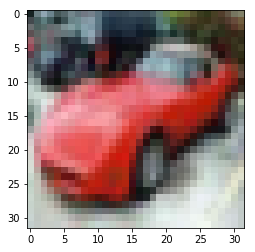

In [7]:
sample=np.random.randint(0,len(x_train))
print("x_train image of : "+str(sample)+" is an image of a "+str(class_dict[y_train[sample][0]]))
plt.imshow(x_train[sample]) 

x_test image of : 8419 is an image of a horse


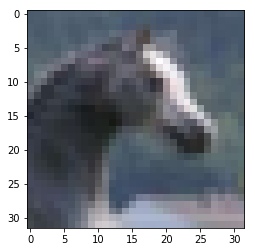

In [8]:
sample=np.random.randint(0,len(x_test))
print("x_test image of : "+str(sample)+" is an image of a "+str(class_dict[y_test[sample][0]]))
plt.imshow(x_test[sample]) 

The image changes everytime randomly each time above code is run. But all images I checked were correct

## Dataset Exploration

lets first observe what kind of input we have and output we desire

In [9]:
x_train.shape # (50000, 32, 32, 3)

(50000, 32, 32, 3)

We have 50000 of 32x32 images in 3 channels (RGB) in the training set

In [10]:
x_test.shape #(10000, 32, 32, 3)

(10000, 32, 32, 3)

We have 10000 of 32x32 images in 3 channels (RGB) in the test set

In [11]:
y_train.shape # original (50000,1)

(50000, 1)

y_train and y_test can be converted into an array because 1 dimension of 1 element means it is an array

In [12]:
y_train=y_train.reshape(-1,) # -1 means we state unknown length of first dimension (stays same)
y_train.shape #(50000, 1)

(50000,)

In [13]:
y_test=y_test.reshape(-1,)
y_test.shape # (10000, 1)

(10000,)

y_train and y_test are arrays for the labels of the training and test sets of x_train and x_test

In [14]:
print("Minimum value of y is: "+str(min(y_train))+
      "\nMaximum value of y is: "+str(max(y_train))+
     "\nThe number of classes is: "+ str(max(y_train)-min(y_train)+1))


Minimum value of y is: 0
Maximum value of y is: 9
The number of classes is: 10


One hot encoding is used to define values ranging from 0 to 9 in this array with a matrix where we have 1 for the corresponding class and 0 for all other classes

In [15]:
depth = 10 # 10 classes
y_test_one_hot=tf.Session().run(tf.one_hot(y_test, depth,on_value=1,off_value=0)).reshape(-1,depth)
y_train_one_hot=tf.Session().run(tf.one_hot(y_train, depth,on_value=1,off_value=0)).reshape(-1,depth)

In [16]:
print("Shape of y_train set with one hot encoding: "+str(y_train_one_hot.shape))
print("Shape of y_test  set with one hot encoding: "+str(y_test_one_hot.shape))

Shape of y_train set with one hot encoding: (50000, 10)
Shape of y_test  set with one hot encoding: (10000, 10)


In [17]:
print("Shape of x_train set: "+str(x_train.shape))
print("Shape of x_test  set: "+str(x_test.shape))

Shape of x_train set: (50000, 32, 32, 3)
Shape of x_test  set: (10000, 32, 32, 3)


To define placeholders we have to decide on the size of input images. From the CNN defined in the question we have 32x32@3 images

In [18]:
y_test_one_hot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [19]:
y_train_one_hot.shape

(50000, 10)

## Shape and Dimensions

The above dimensions can also be given explicitly if we want to have a generic solution that does not depend on the inputs

In [20]:
# We know that CIFAR-10 images are 32 pixels in each dimension.
img_size = 32
# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size
# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)
# Number of classes, one class for each of 10 digits.
num_classes = 10
full_layer_size=128 #predefine fully connected layer neuron number
channel_depth=3 #number of channels
img_size_flat=img_size*img_size*channel_depth #32x32@3

Now if we want to keep the number of images in one dimension and 32x32@3=3072 pixels in one dimension, for this we will reshape:

In [21]:
x_train_flat=x_train.reshape(-1,img_size_flat)
x_test_flat=x_test.reshape(-1,img_size_flat)

In [22]:
print(x_train_flat.shape)
print(x_test_flat.shape)

(50000, 3072)
(10000, 3072)


However we might want to keep images in widthxlength@channel format as we will use conv2d which is 2dimensional convolutional operation

## Define placeholders

Define input and output placeholders. It is a good idea to pass dropout rate also as a placeholder.

In [23]:
x_train_input = tf.placeholder(tf.float32, [None, img_size,img_size,channel_depth])
print(x_train_input)
x_test_input = tf.placeholder(tf.float32, [None, img_size,img_size,channel_depth])
print(x_test_input)

Tensor("Placeholder:0", shape=(?, 32, 32, 3), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 32, 32, 3), dtype=float32)


In [24]:
y_train_output =  tf.placeholder(tf.float32, [None, num_classes])
print(y_train_output)
y_test_output =  tf.placeholder(tf.float32, [None, num_classes])
print(y_test_output)

Tensor("Placeholder_2:0", shape=(?, 10), dtype=float32)
Tensor("Placeholder_3:0", shape=(?, 10), dtype=float32)


My initial thought was to define all train and test inputs and outputs as placeholders, however as their size are not dependent defining x for all inputs and y for all outputs was enough

In [25]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
print(x)

Tensor("Placeholder_4:0", shape=(?, 3072), dtype=float32)


The image_size_flat corresponds to the fully connected layer which is used for classification task

In [26]:
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])
print(y_true)
print(y_true_cls)

Tensor("Placeholder_5:0", shape=(?, 10), dtype=float32)
Tensor("Placeholder_6:0", shape=(?,), dtype=int64)


True predictions and true classes are passed as placeholders, our tensor graph should be able to link inputs to their corresponding outputs

In [27]:
logits=tf.placeholder(tf.float32, [None, num_classes])

Logits is the basic output definition, it is basically defined as y=x*weights+biases

In [28]:
output=tf.placeholder(tf.float32, [None,num_classes])

Output has the same shape and format as logits, basically output is the probability of an image being a class.
Note that we are using softmax which equates the sum of all possibilities to 1, which is mathematically adaquate to assume the corresponding float values are probabilities.

## Define variables

Define filters for convolutional layers, weights and biases for fully connected layers. Don't forget to use an initializer. Xavier is recommended.

<img src="model.png">

In [29]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

Instructions for updating:
Colocations handled automatically by placer.


Defining weights and biases as well as convolutional layers as variables. Convolutional layer outputs are defined as variables here, however they are not again used succesfully.

In [30]:
biases = tf.Variable(tf.zeros([num_classes]))

In [31]:
Conv_layer_1=tf.Variable(tf.zeros([img_size,img_size,channel_depth]))
fully_connected=tf.Variable(tf.zeros([full_layer_size,num_classes]))
print(Conv_layer_1)
print(fully_connected)

<tf.Variable 'Variable_2:0' shape=(32, 32, 3) dtype=float32_ref>
<tf.Variable 'Variable_3:0' shape=(128, 10) dtype=float32_ref>


In [32]:
logits = tf.matmul(x, weights) + biases

## Define network

Define the network as a function.Recommended functions are:

`
tf.nn.convolution / tf.nn.pool / tf.nn.batch_normalization / tf.nn.dropout / tf.reshape`

<img src="model.png">

The above cell gives errors in tensorflow, I could not debug the errors but matrix dimensions and their connections should be correct

In [33]:
#logits = tf.matmul(x, weights) + biases
y_true_cls

<tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=int64>

In [34]:
y_pred = tf.nn.softmax(logits)

In [35]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [36]:
y_pred_cls

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

In [37]:
logits

<tf.Tensor 'add:0' shape=(?, 10) dtype=float32>

## Define cost function

Define cost with respect to predictions and labels.

In [38]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true_cls)
cost = tf.reduce_mean(cross_entropy)

For the sake of completing this training run with the lab1(assignment1) code I choose the same parameters as they were in lab1

## Define optimizer

Adam is recommended

In [39]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [40]:
#optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

GradientDescentOptimizer with fixed learning rate was tried at first, due to training errors I did not move to adaptive gradient descent optimization

## Define performance measures

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [41]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [42]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create TensorFlow session


In [43]:
session = tf.Session()

Initiates a tensorflow session, the output of this session are typical numpy elements

## Initialize variables

The variables for `weights`,`filters` and `biases` must be initialized before we start optimizing them.

In [44]:
session.run(tf.global_variables_initializer())

## Define train function

Don't forget to use batches since dataset is large.

Hint : One of the simplest way to define batch is

`for b in range(dataset_size//batch_size):      
    x_batch = x_train[b * batch_size : (b+1) * batch_size]`

In [45]:
batch_size = 100
dataset_size=x_train.shape[0]

In [46]:
epoch=1

In [47]:
def train(epoch):
    for i in range(epoch):
        for b in range(int(dataset_size/batch_size)): 
            # Get a batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch=x_train_flat[b*batch_size:(b+1)*batch_size]
            y_true_batch=y_train_one_hot[b*batch_size:(b+1)*batch_size]
            #x_batch, y_true_batch = data.train.next_batch(batch_size)
            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            # Note that the placeholder for y_true_cls is not set
            # because it is not used during training.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch}

            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)

In [48]:
y_train

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

## Define test function

Dict with the test-set data to be used as input to the TensorFlow graph. Note that we must use the correct names for the placeholder variables in the TensorFlow graph.

In [49]:
feed_dict_test = {x: x_test_flat, # input is the flat array of images
                  y_true: y_test_one_hot, # true output is the matrix of one hot encoded y_test
                  y_true_cls: y_test} #corresponding class values are given in original y_test

In [50]:
y_true_cls

<tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=int64>

In [51]:
y_test_one_hot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

The feed_dict_test is compared with lab1, they are identical yet my test feed dictionary gives some error I could not fix/debug

In [52]:
feed_dict_test

{<tf.Tensor 'Placeholder_4:0' shape=(?, 3072) dtype=float32>: array([[158, 112,  49, ...,  21,  67, 110],
        [235, 235, 235, ..., 186, 200, 199],
        [158, 190, 222, ...,   7,   8,   7],
        ...,
        [ 20,  15,  12, ...,  25,  20,  47],
        [ 25,  40,  12, ...,  92, 120,  80],
        [ 73,  78,  75, ...,  27,  26,  26]], dtype=uint8),
 <tf.Tensor 'Placeholder_5:0' shape=(?, 10) dtype=float32>: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]]),
 <tf.Tensor 'Placeholder_6:0' shape=(?,) dtype=int64>: array([3, 8, 8, ..., 5, 1, 7])}

In [53]:
y_pred_cls

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

## Performance before training

The accuracy is expected to be around 10%

Peformance metrics are defined below in functions for printing accuracy and getting it as well as plotting weights

In [54]:
def print_accuracy():
    
    # Run the model to get predictions for test data
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # Get true labels
    cls_true = y_test# data.test.cls
    
    # Calculate the difference betweeb predictions and true labels
    correct_prediction = np.equal(cls_pred, cls_true)
    
    # Calculate the total accuracy
    acc = np.mean(correct_prediction)

    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [55]:
def get_accuracy():
    
    # Run the model to get predictions for test data
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # Get true labels
    cls_true = y_test# data.test.cls
    
    # Calculate the difference betweeb predictions and true labels
    correct_prediction = np.equal(cls_pred, cls_true)
    
    # Calculate the total accuracy
    acc = np.mean(correct_prediction)

    # Print the accuracy.
    return acc

In [56]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    

In [57]:
print_accuracy()

Accuracy on test-set: 10.0%


As expected accuracy on test set is 10% which corresponds to 5000 of images being 0 (airplane)in the dataset as we have initialized as all zeros 10% are correctly labeled

## Performance after training

Measure training and test accuracy for at least 10 epochs, show it on a epoch/accuracy graph. The network is expected to reach around 70% accuracy at 10 epochs. 

In [58]:
train(epoch=10)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_6' with dtype int64 and shape [?]
	 [[node Placeholder_6 (defined at <ipython-input-26-f21d8bac7c98>:2) ]]

Caused by op 'Placeholder_6', defined at:
  File "C:\Users\M\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\M\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\M\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\M\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\M\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\M\Anaconda3\lib\asyncio\base_events.py", line 528, in run_forever
    self._run_once()
  File "C:\Users\M\Anaconda3\lib\asyncio\base_events.py", line 1764, in _run_once
    handle._run()
  File "C:\Users\M\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\M\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\gen.py", line 1080, in __init__
    self.run()
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\M\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\M\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\M\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\M\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\M\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\M\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\M\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\M\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\M\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\M\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\M\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\M\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-f21d8bac7c98>", line 2, in <module>
    y_true_cls = tf.placeholder(tf.int64, [None])
  File "C:\Users\M\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\array_ops.py", line 2077, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\M\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gen_array_ops.py", line 6834, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\M\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\M\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\M\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\M\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_6' with dtype int64 and shape [?]
	 [[node Placeholder_6 (defined at <ipython-input-26-f21d8bac7c98>:2) ]]


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_6' with dtype int64 and shape [?]
	 [[node Placeholder_6 (defined at <ipython-input-26-f21d8bac7c98>:2) ]]
        
        InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_6' with dtype int64 and shape [?]
	 [[node Placeholder_6 (defined at <ipython-input-26-f21d8bac7c98>:2) ]]

The training gives the above error, I checked nearly all variables and placeholders as they were in lab1, everything seems identical/similar yet I still get this error

In [59]:
print_accuracy()

Accuracy on test-set: 10.0%


## Close the session

In [60]:
session.close()

## Discussion

I could not be able to debug/fix my code from the errors. From theoretical aspect I can deduce some discussions:
Convolutional Neural Networks (CNNs) are used for automatical filter generation. This term might sound generic but CNNs are very successful at imitating handcrafted science related filters. Instead of scientists/engineers CNNs map their Inputs to the outputs with the help of backpropagation and long training time where CNN is exposed to data.

#### Keynotes and their explanations used in this notebook:

###### Rectified Linear Unit: 
is the nonlinearity that helped Deep Learning shine. Basically with the help of these units (and with many of them) we can fit a formula for a complex (nonlinear) problem.
###### batch normalization: 
Improves performance and stability of neural networks, helps optimization. Normalizes inputs of each layer to have zero mean and standard deviatiof of 1 in output activation. Widely used to combat internal covariate shift. Used after filtering and before activation function (RELU). Regularizes the modeli reduces need for dropout.
###### Dropout:
Combining predictions is a strong method but it is costy. So drop each neuron in the network with a probability p (generally with p=0.5 50% of the time). This way each neuron acts independently and does not rely solely on another neuron. Forces neurons to learn robust features in conjuction with each other. Dropout is only used in training, in test all neurons are available.


In [61]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of filters.
                   num_filters):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    biases =  tf.Variable(tf.constant(0.05, shape=[num_filters]))
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    layer = tf.nn.relu(layer)
    return layer, weights

def pool_layer(input,              # The previous layer.
               num_input_channels, # Num. channels in prev. layer.
               filter_size,        # Width and height of filters.
               num_filters):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    biases =  tf.Variable(tf.constant(0.05, shape=[num_filters]))
    layer += biases
    layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

## Comparing with Keras

In [62]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 100
steps_per_epoch=100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=100,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Using real-time data augmentation.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
	 [[{{node metrics/acc/Mean}}]]

Don't know how but even the keras's CIFAR-10 code I directly copied for reference did not work :)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
	 [[{{node metrics/acc/Mean}}]]

## References

[1] [Arm Community](https://community.arm.com)

[2] [Keras Cifar-10 Example](https://keras.io/examples/cifar10_cnn/)
